In [1]:
library("igraph") |> suppressPackageStartupMessages()

Warning message:
"il pacchetto 'igraph' è stato creato con R versione 4.2.3"


# Watts Strogatz - Small world network
We start by investigating the `XY - model` on the Watts strogats network:
```python
dim	
Integer constant, the dimension of the starting lattice.

size	
Integer constant, the size of the lattice along each dimension.

nei	
Integer constant, the neighborhood within which the vertices of the lattice will be connected.

p	
Real constant between zero and one, the rewiring probability.

loops	
Logical scalar, whether loops edges are allowed in the generated graph.

multiple	
Logical scalar, whether multiple edges are allowed int the generated graph.
```

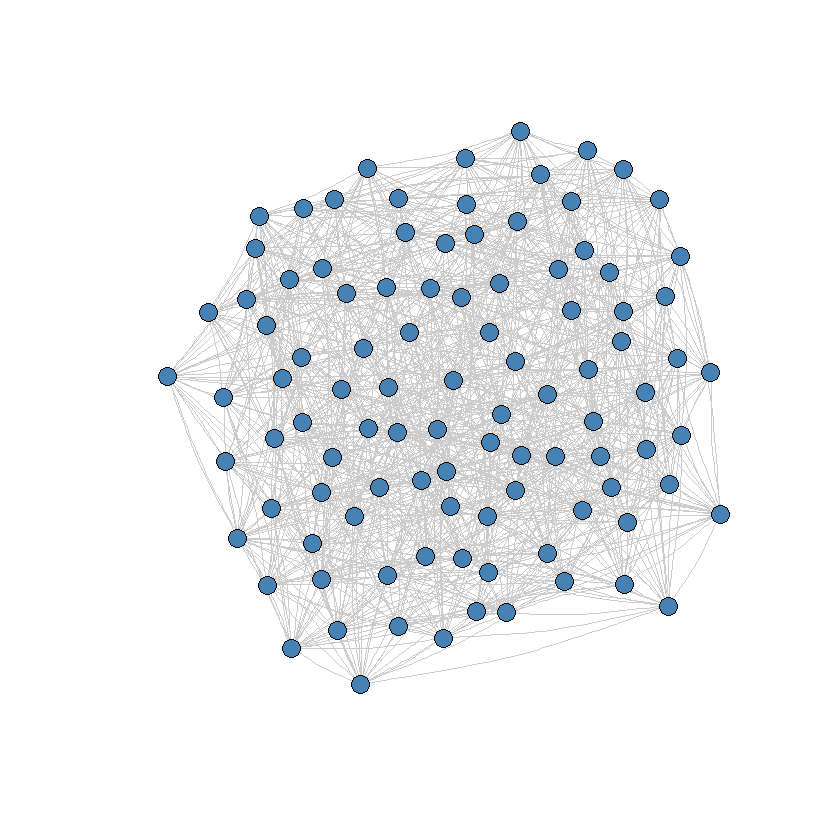

In [2]:
dim <- 2 # 2D
size <- 10
nei <- 3
p <- 0.1
g <- sample_smallworld(dim = dim, size = size, nei = nei, p = p, loops = FALSE, multiple = FALSE)
plot(g, vertex.color="steelblue", edge.curved=0.1, edge.color="gray80", vertex.label=NA, vertex.size=7)

In [3]:
get.adjacency(g)

100 x 100 sparse Matrix of class "dgCMatrix"
                                                                              
  [1,] . 1 . 1 . 1 . 1 1 1 1 . . . . . . . 1 . 1 1 . 1 1 . . . . . . . . . . .
  [2,] 1 . 1 1 1 . . . 1 1 1 1 1 1 . . . . . 1 . . 1 . . . . . . . . 1 . . . .
  [3,] . 1 . 1 1 . . . . 1 1 1 . 1 1 . . . . . . 1 1 1 . . . . . . . . 1 . . .
  [4,] 1 1 1 . 1 1 1 . 1 . . 1 1 1 1 . . . . . . . 1 1 1 . . . . . . . . 1 . .
  [5,] . 1 1 1 . 1 1 . . . . . 1 1 1 1 1 1 . . . 1 . 1 1 1 . . . . . . . . . .
  [6,] 1 . . 1 1 . 1 1 . . . . . 1 1 1 1 . . . . . . . 1 1 1 . . . 1 . 1 . . 1
  [7,] . . . 1 1 1 . 1 . 1 1 . . . 1 1 1 1 1 . . . . . . 1 1 . . 1 . . . . . .
  [8,] 1 . . . . 1 1 . 1 1 . . . . . 1 1 1 1 1 . . . . . . 1 . 1 . . . . . . .
  [9,] 1 1 . 1 . . . 1 . . 1 . . . . . . 1 1 . . . . . . . . 1 1 1 . . . . 1 1
 [10,] 1 1 1 . . . 1 1 . . 1 1 . . . . . 1 1 1 1 . . . . . . . 1 1 . . 1 . . .
 [11,] 1 1 1 . . . 1 . 1 1 . 1 1 1 . . . 1 1 . 1 . . . . . . . 1 1 . 1 . . . .
 [12,] 

In [4]:
# get.adjacency(g)

# $\braket{m} = \frac{\braket{M}}{N} = \frac{1}{N}|\braket{\textbf{s}}| = \frac{1}{N}|\braket{\displaystyle\sum_{i=1}^N cos \:\theta_i, \displaystyle\sum_{i=1}^N sin \:\theta_i}|$
## where $N = L \times L $
## $\braket{m^2} = \frac{\braket{M^2}}{N^2} = \frac{1}{N^2}|\braket{s_x^2+s_y^2}| = \frac{1}{N^2}|\braket{\displaystyle(\sum_{i=1}^N cos \:\theta_i)^2 + \displaystyle(\sum_{i=1}^N sin \:\theta_i)^2}|$


In [5]:
H_matrix_calc <- function(size, mat, angles.samples){
    H <- matrix(0, size, size)
    N <- size^2
    for (i in 0:(N - 1)){
        row <- (i %/% size)+1; col <- (i %% size)+1
        # cat("row = ", row, "col = ", col, "\n")
        for (j in (mat[[i+1]]-1)){
            # These are all the n.n.
            new.row <- (j %/% size)+1; new.col <- (j %% size)+1
            H[row, col] <- H[row, col] - cos(angles.samples[row, col] - angles.samples[new.row, new.col]) 
        }
    }
    co <- mean(cos(angles.samples))
    si <- mean(sin(angles.samples))
    return(list(H = H, co = co, si = si))
}

In [6]:
# H_matrix_calc(10, mat, angles.samples)

In [7]:
# angles.samples <- matrix(data = runif(n = 100, min = 0, max = 2*pi), nrow = 10, ncol = 10, byrow = TRUE)
# g <- sample_smallworld(dim = dim, size = 10, nei = nei, p = p, loops = FALSE, multiple = FALSE)
# mat <- get.adjlist(g)        

In [8]:
compute_delta_H <- function(size, mat, angles.samples, T, H){
    change_pos <- sample(size, 2)
    new_angles <- angles.samples
    # old_val <- angles.samples[change_pos[1], change_pos[2]]
    new_val <- runif(1, -0.2, 0.2)

    new_angles[change_pos[1], change_pos[2]] <- new_angles[change_pos[1], change_pos[2]] + new_val
    
    H.new <- sum(H_matrix_calc(size, mat, new_angles)$H)/2
    delta_H <- H.new - H

    # Metropolis passage
    if (delta_H > 0){
        if (runif(n = 1, min = 0, max = 1) < exp(-delta_H/T)){
            angles.samples <- new_angles
            H <- H.new
        }
    }
    else{
        angles.samples <- new_angles
        H <- H.new
    }
    return(list(angles.samples = angles.samples, H = H))
}

In [9]:
get_specific_heat <- function(all_H, T){
    # actual.vals <- as.integer(length(all_H)/10)
    # len <- length(all_H)
    return(var(all_H)/T^2)
}

In [10]:
# N <- size^2
NN <- c(100)#, 225, 400)#, 400, 1600, 3200)
Temperature <- seq(2, 2.4, 0.025)
# probs <- seq(0, 1, 0.1)
p <- 0.2
runs <- 1:10
iter_per_step <- 1:10000
m <- c(); m.2 <- c(); m.4 <- c()
specific_heat <- c()
for (N in NN){
    size <- sqrt(N)
    g <- sample_smallworld(dim = dim, size = size, nei = nei, p = p, loops = FALSE, multiple = FALSE)
    mat <- get.adjlist(g)
    angles.samples <- matrix(data = runif(n = vcount(g), min = -pi, max = pi), nrow = size, ncol = size, byrow = TRUE)        
    for (T in Temperature){
        magn <- c(); all_H <- c(); m_squared <- c(); m_fourth <- c()
        result <- H_matrix_calc(size = size, mat = mat, angles.samples = angles.samples)
        H_matrix <- result$H; co <- result$co; si <- result$si
        # magn <- append(magn, norm(c(co, si), type="2"))
        H <- sum(H_matrix)/2
        # all_H <- append(all_H, H)   
        for (run in runs){
            for (iter in iter_per_step){
                res <- compute_delta_H(size, mat, angles.samples, T, H)
                angles.samples <- res$angles.samples; H <- res$H
            }
            # result <- H_matrix_calc(size = size, mat = mat, angles.samples = angles.samples)
            # H_matrix <- result$H; co <- result$co; si <- result$si
            # H <- sum(H_matrix)/2
            co <- mean(cos(angles.samples))
            si <- mean(sin(angles.samples))
            all_H <- append(all_H, H)
            
            # Compute magnetization and higer orders of m
            m_temp <- c(co, si)
            m_2 <- sum(m_temp^2)
            m_4 <- m_2^2

            # Save results for each run
            magn <- append(magn, norm(m_temp, type="2"))
            m_squared <- append(m_squared, m_2)
            m_fourth <- append(m_fourth, m_4) 
        }

        specific_heat <- append(specific_heat, get_specific_heat(all_H, T))
        # Take the average for each run, so to have only one value per temperature
        m <- append(m, mean(magn))
        m.2 <- append(m.2, mean(m_squared))
        m.4 <- append(m.4, mean(m_fourth))
    }
}
U.N.T <- 1 - m.4/(3*(m.2^2))

In [ ]:
m.4

[1] 0.0014865422 0.1838155222 0.4718908697 0.4879034727 0.4731389596
 [6] 0.4771125205 0.4696654892 0.5083531136 0.4808034708 0.4901986754
[11] 0.4880618557 0.4951562037 0.4934204939 0.4942565012 0.5187700333
[16] 0.5089607432 0.5037222197 0.0004236060 0.0115200854 0.1245524987
[21] 0.4234429606 0.6227494747 0.6761679606 0.6781804985 0.6793333607
[26] 0.6635120500 0.6647324211 0.6677725594 0.6717933877 0.6503098385
[31] 0.6584678279 0.6564382828 0.6557038462 0.6664904776 0.0001639887
[36] 0.0015003761 0.0077270328 0.0394055164 0.1254216856 0.2697349310
[41] 0.4178746270 0.5176821319 0.5910834917 0.6185892000 0.6351713638
[46] 0.6269861818 0.6319398959 0.6385298351 0.6326565171 0.6112850917
[51] 0.6232860494

In [ ]:
m.2

[1] 0.02828964 0.38209551 0.68688583 0.69841259 0.68766928 0.69066118
 [7] 0.68527982 0.71288797 0.69329561 0.70011254 0.69855618 0.70359693
[13] 0.70235435 0.70295062 0.72012541 0.71329951 0.70945951 0.01839537
[19] 0.09858527 0.34128076 0.64655576 0.78894949 0.82228044 0.82345251
[25] 0.82419694 0.81454620 0.81527691 0.81715255 0.81960091 0.80638910
[31] 0.81142198 0.81017160 0.80972843 0.81636980 0.01156185 0.03777286
[37] 0.08519134 0.19423663 0.35087223 0.51707945 0.64597348 0.71927969
[43] 0.76877419 0.78648830 0.79696188 0.79181974 0.79494098 0.79907271
[49] 0.79536585 0.78182773 0.78947557

In [ ]:
U.N.T

[1] 0.3808425 0.5803212 0.6666111 0.6665824 0.6664905 0.6665970 0.6666262
 [8] 0.6665723 0.6665663 0.6666387 0.6666113 0.6665942 0.6665863 0.6665878
[15] 0.6665449 0.6665589 0.6664088 0.5827235 0.6048970 0.6435427 0.6623539
[22] 0.6665016 0.6666554 0.6666143 0.6666506 0.6666533 0.6666386 0.6666496
[29] 0.6666430 0.6666429 0.6666352 0.6666361 0.6666444 0.6666512 0.5910806
[36] 0.6494750 0.6451044 0.6518443 0.6604112 0.6637197 0.6661931 0.6664612
[43] 0.6666273 0.6666530 0.6666545 0.6666626 0.6666621 0.6666601 0.6666405
[50] 0.6666500 0.6666590

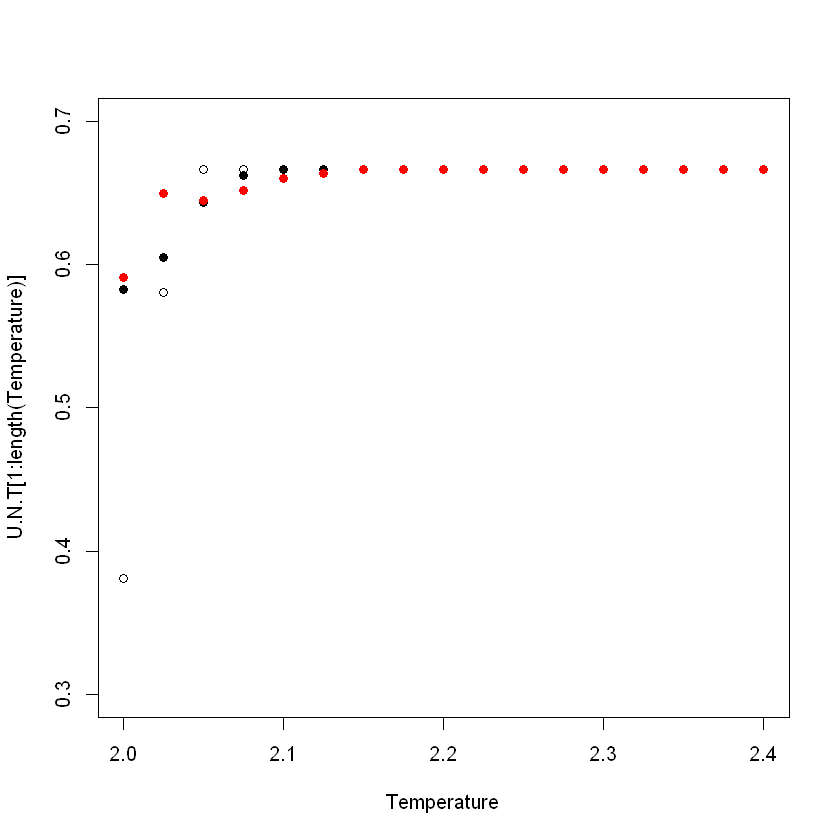

In [ ]:
plot(Temperature, U.N.T[1:length(Temperature)], ylim=c(0.3, 0.7))
points(Temperature, U.N.T[(length(Temperature)+1):(2*length(Temperature))], pch=16)    
points(Temperature, U.N.T[(2*(length(Temperature))+1):(3*length(Temperature))], pch=16, col="red")    

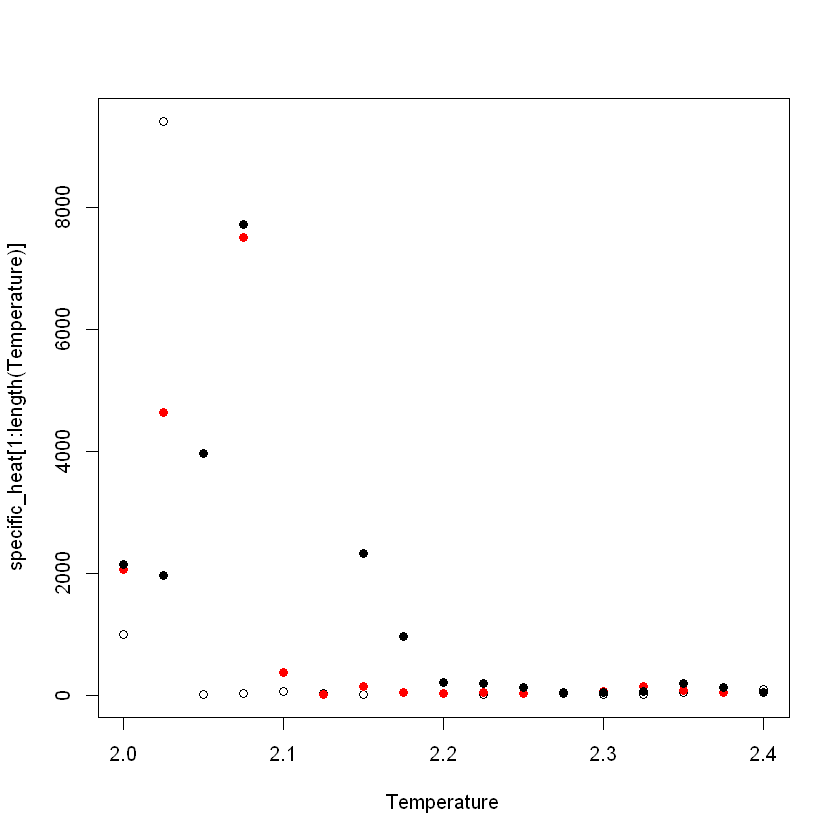

In [ ]:
plot(Temperature, specific_heat[1:length(Temperature)])
points(Temperature, specific_heat[(length(Temperature)+1):(2*length(Temperature))], pch=16, col="red")
points(Temperature, specific_heat[(2*length(Temperature)+1):(3*length(Temperature))], pch=16)